In [1]:
#いまさらながらKMeans
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.mixture import BayesianGaussianMixture
from sklearn.manifold import TSNE
import umap

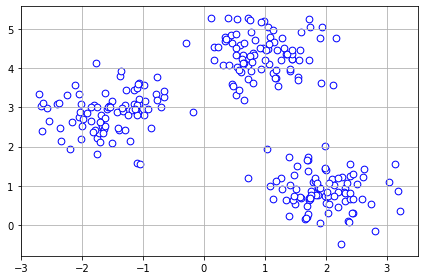

In [2]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

X,y = make_blobs(n_samples=265,
                 n_features=2,#特徴量の数
                 centers=3,#クラスタの個数
                 cluster_std=0.5,#クラスタ内の分布の標準偏差
                 shuffle=True,#shuffle data
                 random_state=0)

#plot
plt.scatter(X[:,0],X[:,1],c='white',marker='o',edgecolor='b',s=45)
plt.grid()
plt.tight_layout()

C:\Users\unlea\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


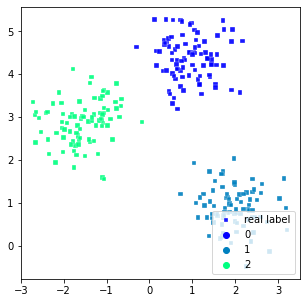

In [3]:
km = KMeans(n_clusters=3,#cluster num
            init='k-means++',#重心初期点を互いになるべく離れた位置に配置するようKMeans++
            max_iter=500,#収束までに繰り返すイタレーション数
            tol=1e-4,#クラスタ内SSEが、この値以上に小さくならない、つまり改善しないならそこでイテレーションstop
            n_init=25,#そのつど異なるセントロイドを使ってクラスタリングを25回実行し、最もイナーシャ(重心とのSSE和)が小さいモデルを採択
            random_state=0)

#ラベルの予測をfit_predictで予測
y_km = km.fit_predict(X)

#実際の正解ラベルと比べてどうであった？
plt.figure(figsize=(5,5))
sns.scatterplot(X[:,0],X[:,1],hue=y,marker='s',palette='winter',alpha=.9,s=20,label='real label')

plt.legend(loc='lower right')

C:\Users\unlea\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

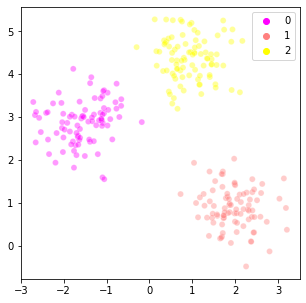

In [4]:
plt.figure(figsize=(5,5))
sns.scatterplot(X[:,0],X[:,1],hue=y_km,marker='o',palette='spring',alpha=.4)

In [5]:
#KMeanのイナーシャ(各クラスタに属すると判定された点たちの、クラスタ重心とのユークリッド距離の和)
print(km.inertia_)

131.44006174698185


C:\Users\unlea\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


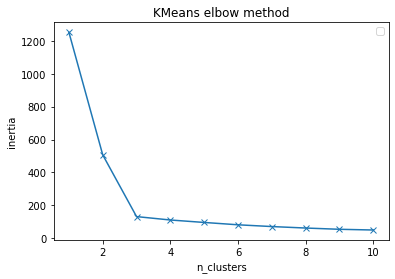

In [6]:
#エルボー法で、n_clustersはどの値にするのが良いか(つまりinertiaが急に減り始めるのはどのn_clusterからなのか？)
inertias = []
for i in range(1,11):
    km = KMeans(n_clusters=i,
                init='k-means++',
                n_init=15,
                max_iter=500,
                random_state=0)
    
    km.fit(X)
    inertias.append(km.inertia_)
    
plt.plot(range(1,11),inertias,marker='x')
plt.title('KMeans elbow method')
plt.xlabel('n_clusters')
plt.ylabel('inertia')
plt.legend()
#この結果を見ると、クラスタ数は3から急にエルボーが落ち込んでいるのであり、それ以上クラスタ数を増やしても大してイナーシャは減っていないこと
#がわかる。つまり最適なクラスタ数は3くらいかな？とおもわれ。

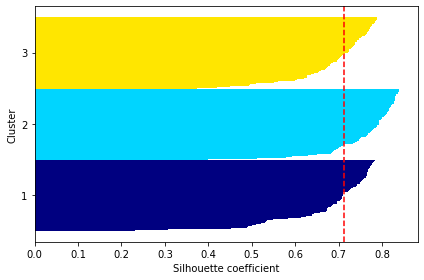

In [7]:
#クラスタリングの性能評価の指標の一つとして、シルエット分析というのがある
import numpy as np
from matplotlib import cm
from sklearn.metrics import silhouette_samples

km = KMeans(n_clusters=3, 
            init='k-means++', 
            n_init=10, 
            max_iter=300,
            tol=1e-04,
            random_state=0)
y_km = km.fit_predict(X)

cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(X, y_km, metric='euclidean')
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, 
             edgecolor='none', color=color)

    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)
    
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color="red", linestyle="--") 

plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')

plt.tight_layout()
#plt.savefig('images/11_04.png', dpi=300)
plt.show()

シルエット係数の値が１に近ければ、各クラスタはよいクラスタリング、とうことになる。またクラスタごとのシルエット係数の大きさが異なる場合は<br>
悪いクラスタリングとなっている

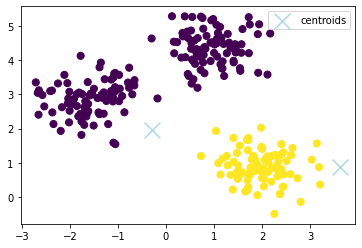

In [8]:
#悪いクラスタリングの例
km = KMeans(n_clusters=2, 
            init='k-means++', 
            n_init=10, 
            max_iter=300,
            tol=1e-04,
            random_state=0)
y_km = km.fit_predict(X)

plt.scatter(X[:,0],X[:,1],c=y_km,s=50)#クラスタ結果散布図
plt.scatter(km.cluster_centers_[0],#各クラスタの重心を散布図にプロット
            km.cluster_centers_[1],
            s=250,
            marker='x',
            c='lightblue',
            label='centroids')
plt.legend()


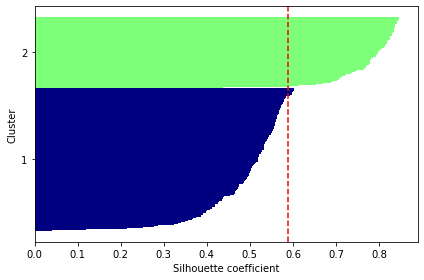

In [9]:
cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(X, y_km, metric='euclidean')
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), (c_silhouette_vals), height=1.0, 
             edgecolor='none', color=color)

    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)
    
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color="red", linestyle="--") 

plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')

plt.tight_layout()
#plt.savefig('images/11_04.png', dpi=300)
plt.show()

クラスタ=2でKMした結果をみると、シルエット値がクラスタ１と２で差があり、うまいクラスタリングとはなっていないことがわかる

In [10]:
#凝集型クラスタリングについて学ぶ

#まずテスト用のデータセットを作る
import pandas as pd
import numpy as np

np.random.seed(12)

variables = ['X','Y','Z']
labels = ['ID_0','ID_1','ID_2','ID_3','ID_4']

X = np.random.random_sample([5,3])*10#5*3形状の、0以上1未満からなる乱数行列生成

X_df = pd.DataFrame(X,columns=variables,index=labels)
X_df

,X,Y,Z
ID_0,1.541628,7.400497,2.633150
ID_1,5.337394,0.145750,9.187470
ID_2,9.007149,0.334214,9.569493
ID_3,1.372093,2.838284,6.060832
ID_4,9.442251,8.527355,0.022592


In [11]:
#このdfに基づき距離行列を計算してみる
from scipy.spatial.distance import pdist,squareform #spatial.distanceのさぶもじゅーるであるpdist関数を使う

#pdistで距離を計算,squareformで対象行列を作成
row_dist = pd.DataFrame(squareform(pdist(X_df,metric='euclidean')),columns=labels,index=labels)
row_dist#距離行列を作成すると、indexの各IDのデータポイント同士の距離をあらわす対称行列ができる

,ID_0,ID_1,ID_2,ID_3,ID_4
ID_0,0.000000,10.488008,12.400774,5.708900,8.396706
ID_1,10.488008,0.000000,3.694396,5.722693,13.080373
ID_2,12.400774,3.694396,0.000000,8.767847,12.588097
ID_3,5.708900,5.722693,8.767847,0.000000,11.573821
ID_4,8.396706,13.080373,12.588097,11.573821,0.000000


In [12]:
#この距離行列にもとづき、凝集型クラスタリングを行うためにscipy.cluster.hierarchyモジュールのlinkage関数を使う
from scipy.cluster.hierarchy import linkage
help(linkage)

Help on function linkage in module scipy.cluster.hierarchy:

linkage(y, method='single', metric='euclidean', optimal_ordering=False)
    Perform hierarchical/agglomerative clustering.
    
    The input y may be either a 1-D condensed distance matrix
    or a 2-D array of observation vectors.
    
    If y is a 1-D condensed distance matrix,
    then y must be a :math:`\binom{n}{2}` sized
    vector, where n is the number of original observations paired
    in the distance matrix. The behavior of this function is very
    similar to the MATLAB linkage function.
    
    A :math:`(n-1)` by 4 matrix ``Z`` is returned. At the
    :math:`i`-th iteration, clusters with indices ``Z[i, 0]`` and
    ``Z[i, 1]`` are combined to form cluster :math:`n + i`. A
    cluster with an index less than :math:`n` corresponds to one of
    the :math:`n` original observations. The distance between
    clusters ``Z[i, 0]`` and ``Z[i, 1]`` is given by ``Z[i, 2]``. The
    fourth value ``Z[i, 3]`` represents t

In [13]:
#距離行列をもとにして、凝集型クラスタリングを実施するときの、ペアを次々作ってクラスタリングを行う手続きを表す行列作成
row_clusters = linkage(X_df.values,method='ward',metric='euclidean')#method:ward法
pd.DataFrame(row_clusters,
             columns=['row_label1',
                      'row_label2',
                      'dist',
                      'no of items in cluster'],
                      index=['cluster %d' % (i+1) for i in range(row_clusters.shape[0])])

,row_label1,row_label2,dist,no of items in cluster
cluster 1,1.0,2.0,3.694396,2.0
cluster 2,0.0,3.0,5.708900,2.0
cluster 3,4.0,6.0,11.200066,3.0
cluster 4,5.0,7.0,14.483816,5.0


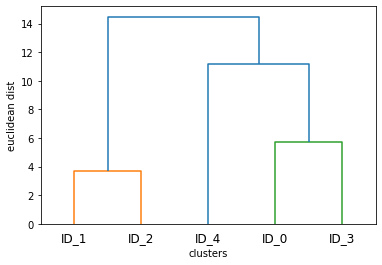

In [14]:
#ようわからんのでデンドログラムで可視化してみる
from scipy.cluster.hierarchy import dendrogram

row_dd = dendrogram(row_clusters,
                   labels=labels)
plt.ylabel('euclidean dist')
plt.xlabel('clusters')
plt.show()

In [15]:
#ここまでの手法は、sklearnのagglomerativeclusteringでサポートされている
from sklearn.cluster import AgglomerativeClustering as AC

ac = AC(n_clusters=3,
        affinity='euclidean',#距離指標
        linkage='ward')#クラスタ同士の連結法。他にはcomplete(クラスタ同士の最遠点同士の距離をクラスタ距離とする方法)やsingle：最近点同士の距離、など

labels = ac.fit_predict(X)

print('cluster labels: {}'.format(labels))#クラスタの分類結果を見ると、うえで見たデンドログラムと一致していることがわかる

cluster labels: [0 1 1 0 2]


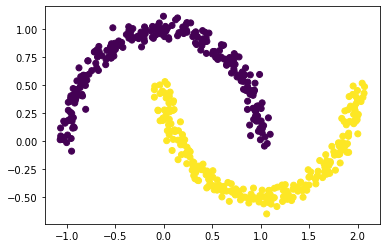

In [21]:
#DBSCANを試してみる
from sklearn.datasets import make_moons
from sklearn.cluster import DBSCAN

X,y = make_moons(n_samples=500,
                 noise=0.05,
                 random_state=0)
#moon dataset
plt.scatter(X[:,0],X[:,1],c=y)

C:\Users\unlea\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
C:\Users\unlea\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


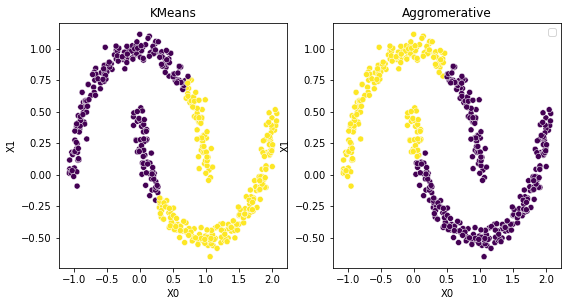

In [45]:
#このデータセットに対して、kmeansとaggromerativeの2つを試してみる
f,(ax1,ax2) = plt.subplots(1,2,figsize=(9,4.5))

km = KMeans(n_clusters=2,random_state=0)
y_km = km.fit_predict(X)

ac = AC(n_clusters=2,linkage='ward')
y_ac = ac.fit_predict(X)
for title,pred,ax in zip(('KMeans','Aggromerative'),(y_km,y_ac),(ax1,ax2)):
    sns.scatterplot(X[:,0],X[:,1],c=pred,ax=ax)
    ax.set_xlabel('X0')
    ax.set_ylabel('X1')
    ax.set_title(title)
    plt.legend()

C:\Users\unlea\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


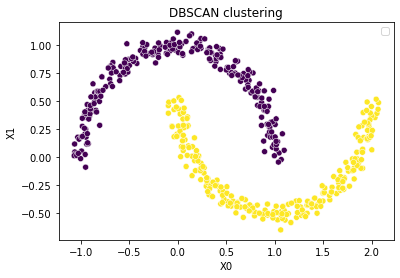

In [54]:
#いずれも非同心円型のデータ分布に対しては、うまくクラスタリングができていない
#ここでDBSCAN
db = DBSCAN(eps=.2,#隣接点とみなすにあたっての最大距離
            min_samples=5,#コア点がコア点たりうるには周りに何個の隣接点が最低必要か
            metric='euclidean')#距離の計測方法

y_db = db.fit_predict(X)

sns.scatterplot(X[:,0],X[:,1],c=y_db)
plt.title('DBSCAN clustering')
plt.xlabel('X0')
plt.ylabel('X1')
plt.legend()